<a href="https://colab.research.google.com/github/haribharadwaj/notebooks/blob/main/BME511/Multitaper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multitaper Spectrum Estimate

We saw with the periodogram, and tapered periodogram how the tapering can reduced bias leaking to far away frequencies because the Fourier transform of the tapering window has smaller side lobes than a ```sinc``` function.

Then with the Welch method, we chopped the data is smaller segments to create more "trials". The reduced duration leads to larger bias, but the averaging across trials gives you lower variance. This is a classic example of bias-variance tradeoff.

However, with the methods discussed so far, the choice of windowing was somewhat arbitrary. What if we wanted to know which window/taper has the smallest side lobes for any given main-lobe size? That would be an "optimal" taper. Trying to answer this question naturally leads to the Slepian tapers and the multitaper estimate.

In [1]:
import numpy as np
import pylab as pl

# Setting it so figs will be a bit bigger
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.33]
plt.rcParams['figure.dpi']  = 120

## Example AR(6) signal from Babadi & Brown (2014)

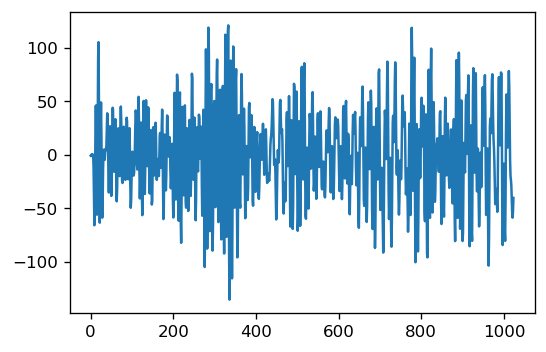

In [2]:
fs = 1024
N = 1024  # 1 second duration
e = np.random.randn(N)

# This is an AR(6) process so we initialize 6 samples with noisN
x = np.zeros(N)
x[:6] = e[:6] 

# Note that AR coefficients are in "samples" units, not seconds
for k in range(7, N):
    x[k] = 3.9515*x[k-1] - 7.8885*x[k-2] + 9.734*x[k-3] - 7.7435*x[k-4] + 3.8078*x[k-5] - 0.9472*x[k-6] + e[k];

pl.plot(x)

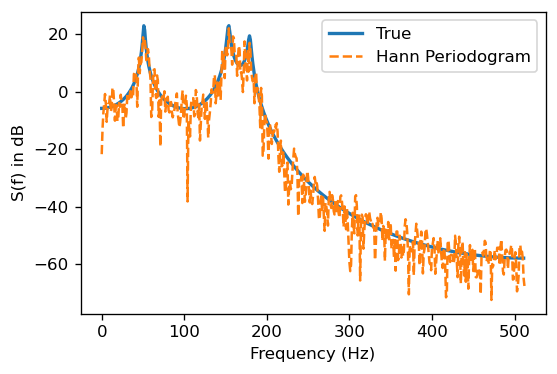

In [3]:
from scipy import signal
h_ar = np.asarray([1, -3.9515, 7.8885, -9.734, 7.7435, -3.8078, 0.9472])
Nfft = N
H = np.fft.fft(h_ar, n=Nfft)
f = np.arange(0, Nfft) * fs/Nfft
H = H[f < fs/2]
f_true = f[f < fs/2]
S_true = 2 * 1 / (np.abs(H) ** 2) / Nfft

pl.plot(f_true, 10*np.log10(S_true), linewidth=2)

# Tapered periodogram
f_periodogram, S_periodogram = signal.periodogram(x, window='hann', fs=fs)
pl.plot(f_periodogram, 10*np.log10(S_periodogram), '--')
pl.xlabel('Frequency (Hz)')
pl.ylabel('S(f) in dB')
pl.legend(('True', 'Hann Periodogram'))

## Generate Slepian tapers

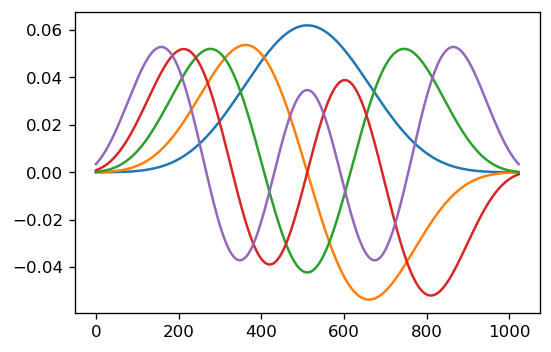

In [4]:
NW = 4
Kmax = 5

# Return concentrations too using return_ratios=True
wins, concentrations = signal.windows.dpss(N, NW, Kmax=Kmax, return_ratios=True)

pl.plot(wins.T)

If ```Kmax << 2 * NW - 1```, concentration should essentiall be 100% (i.e., close to 1.0)

(0.0, 1.1)

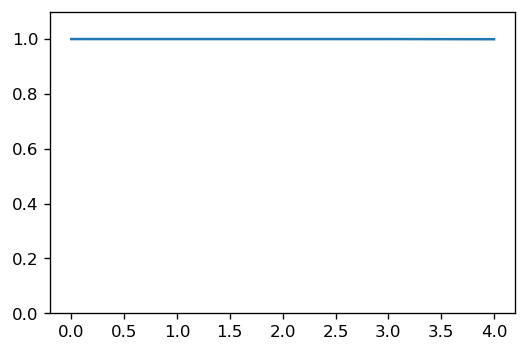

In [5]:
pl.plot(concentrations)
pl.ylim([0, 1.1])

## Spectrum estimate using multiple DPSS windows

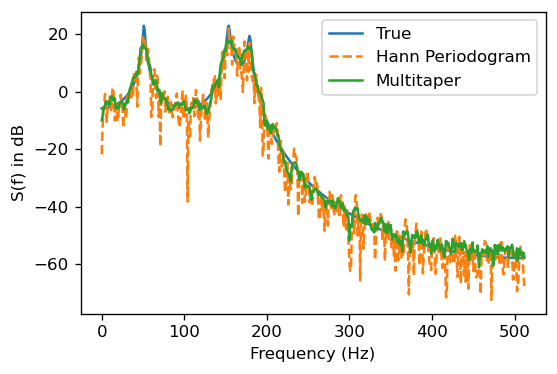

In [6]:
S_mt = 0
for ktap in range(Kmax):
    f_mt, S_temp = signal.periodogram(x, window=wins[ktap, :], fs=fs)
    S_mt += S_temp 
S_mt /= Kmax

pl.plot(f_true, 10*np.log10(S_true))
pl.plot(f_periodogram, 10*np.log10(S_periodogram), '--')
pl.plot(f_mt, 10*np.log10(S_mt))

pl.xlabel('Frequency (Hz)')
pl.ylabel('S(f) in dB')
pl.legend(('True', 'Hann Periodogram', 'Multitaper'))

# Compare Welch and MT methods with similar spectral resolution

That is, what if we match the main-lobe size?

To match the spectral resolution of MT with NW = 4, we need 4 segments with the Welch method

Text(0, 0.5, 'S(f) in dB')

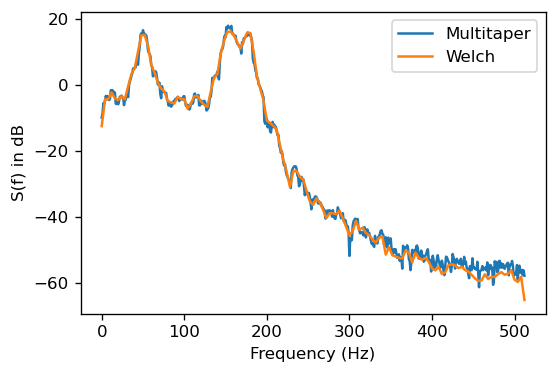

In [7]:
pl.plot(f_mt, 10*np.log10(S_mt))
f_welch, S_welch = signal.welch(x, window='hann', nperseg=N/4, fs=fs)
pl.plot(f_welch, 10*np.log10(S_welch))
pl.xlabel('Frequency (Hz)')
pl.legend(('Multitaper', 'Welch'))
pl.ylabel('S(f) in dB')